 # Temporal missing pattern
Similar to the last section, we will now look at the $\texttt{FIM}$ model. We will again generate some data, write some preprocessing function and delve deeper into the arguments of this model! Remember that the $\texttt{FIM}$ tries to impute a whole range of values over some timeframe for which local simplicity can no longer be assumed.

In [107]:
from fim.models.imputation import FIMImputationWindowed
from datasets import load_dataset
from tutorial_helper import prepare_data
import torch
model = FIMImputationWindowed.from_pretrained("FIM4Science/fim-windowed-imputation")

## Imputing a temporal missing pattern
We again start by generating some data, similar to the last two sections:

In [108]:
data = load_dataset("FIM4Science/roessler-example", download_mode="force_redownload", name="default")["train"] 
data.set_format("torch")
ts=data["t"][:].reshape(1,1,4096,1)
observed_x=data["x"][:].reshape(1,1,4096,1)*(1+torch.normal(0,0.05,size=(1,4096,1)))
observed_v=data["x_prime"][:].reshape(1,1,4096,1)
observed_a=data["x_double_prime"][:].reshape(1,1,4096,1)

data/train-00000-of-00001.parquet:   0%|          | 0.00/230k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4096 [00:00<?, ? examples/s]

Sadly the function needed to prepare our data for this model is a bit more lengthy. New users can either use this version, which assumes 3 windows (Start window, Imputation window, End Window), the version from ```tutorial_help.py``` which also supports 5 windows or write their own preprocessing function. This function then should follow the structure of the output of this function, i.e. a dictionary with the same keys and the described dimensions! The output should therefore have the following keys with the indicated shapes, where wc is the window count, B the batch size and D the dimension:

|  Key  | Shape |
| ----- | ----- |
|location_times | [B, wlen_locs, 1] | 
|observation_times | [B, wc, wlen, D] | 
|observation_values | [B, wc, wlen, D] | 
|observation_mask | [B, wc, wlen, D] | 
|linitial_conditions | [B, D] | 
|rinitial_conditions | [B, D] | 
| padding_mask_locations | [B, wlen_locs] |

With all that hard work, we can now impute the missing values as before. Following the paper we impute the center 20% of the dataset:

In [109]:
imp_start=675
imp_end=700
batch= prepare_data(ts,observed_x,imp_start=imp_start,imp_end=imp_end)
with torch.no_grad():
    prediction_x=model(batch)["imputation_window"]["learnt"]
    prediction_velocity=model(batch)["imputation_window"]["drift"]

Similar to the $\texttt{FIM-}\ell$ model, $\texttt{FIM-}$ returns more then just the learned values, here is a complete list of the structure of the output:
```
{
    "imputation_window": {
        "learnt": learnt_imp_solution,
        "target": batch.get("target_sample_path", None),
        "locations": locations,
        "drift": learnt_imp_drift,
        "drift_certainty": learnt_imp_certainty,
        "padding_mask_locations": batch.get("padding_mask_locations", None),
    },
    "observations": {
        "values": obs_values,
        "mask": obs_mask,
        "times": obs_times,
        "denoised_values": obs_values_processed.view(B, wc, wlen, D),
        "interpolation": interpolation_solution,
        "drift": interpolation_drift,
        "drift_certainty": interpolation_certainty,
    },
}
```

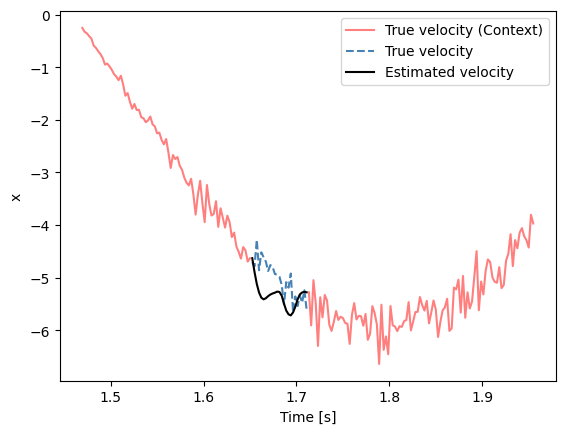

In [116]:
import matplotlib.pyplot as plt 
plt.plot(ts.flatten()[600:imp_start],observed_x.flatten()[600:imp_start],label="True velocity (Context)", c="red", alpha=0.5)
plt.plot(ts.flatten()[imp_end:800],observed_x.flatten()[imp_end:800], c="red", alpha=0.5)
plt.plot(ts.flatten()[imp_start:imp_end],observed_x.flatten()[imp_start:imp_end],linestyle="dashed",label="True velocity", c="steelblue")
plt.plot(ts.flatten()[imp_start:imp_end],prediction_x.flatten(),label="Estimated velocity", c="black")
plt.xlabel("Time [s]")
plt.ylabel("x")
plt.legend()
plt.show()